<a href="https://colab.research.google.com/github/aaaaaamah99/Computer_Vision/blob/main/Task_2/ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nur Rahmah Abdullah

**Vision Transformer**

---




In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Clone repository and pull latest changes.
![ -d vision_transformer ] || git clone --depth=1 https://github.com/google-research/vision_transformer
!cd vision_transformer && git pull

Already up to date.


In [3]:
# Colab already includes most of the dependencies, so we only install the delta:
!pip install einops>=0.3.0 ml-collections>=0.1.0 aqtp>=0.2.0 clu>=0.0.3 git+https://github.com/google/flaxformer tensorflow-text>=2.9.0

#!pip install -qr vision_transformer/vit_jax/requirements.txt

  Running command git clone --filter=blob:none --quiet https://github.com/google/flaxformer /tmp/pip-req-build-6ko0s413


# Import

In [4]:
# Shows all available pre-trained models.
!gsutil ls -lh gs://vit_models/imagenet*
!gsutil ls -lh gs://vit_models/sam
!gsutil ls -lh gs://mixer_models/*

gs://vit_models/imagenet21k+imagenet2012/:
377.57 MiB  2020-11-30T16:17:02Z  gs://vit_models/imagenet21k+imagenet2012/R50+ViT-B_16.npz
330.29 MiB  2020-10-29T17:05:52Z  gs://vit_models/imagenet21k+imagenet2012/ViT-B_16-224.npz
 331.4 MiB  2020-10-20T11:48:22Z  gs://vit_models/imagenet21k+imagenet2012/ViT-B_16.npz
336.89 MiB  2020-10-20T11:47:36Z  gs://vit_models/imagenet21k+imagenet2012/ViT-B_32.npz
334.78 MiB  2021-03-12T09:04:16Z  gs://vit_models/imagenet21k+imagenet2012/ViT-B_8.npz
  1.13 GiB  2020-10-29T17:08:31Z  gs://vit_models/imagenet21k+imagenet2012/ViT-L_16-224.npz
  1.14 GiB  2020-10-20T11:53:44Z  gs://vit_models/imagenet21k+imagenet2012/ViT-L_16.npz
  1.14 GiB  2020-10-20T11:50:56Z  gs://vit_models/imagenet21k+imagenet2012/ViT-L_32.npz

gs://vit_models/imagenet21k/:
450.23 MiB  2021-01-20T14:12:43Z  gs://vit_models/imagenet21k/R26+ViT-B_32.npz
439.85 MiB  2020-11-30T10:10:15Z  gs://vit_models/imagenet21k/R50+ViT-B_16.npz
  1.31 GiB  2021-01-20T14:11:54Z  gs://vit_models/ima

In [5]:
# Download a pre-trained model.

# Note: you can really choose any of the above, but this Colab has been tested
# with the models of below selection...
model_name = 'ViT-B_32'  #@param ["ViT-B_32", "Mixer-B_16"]

if model_name.startswith('ViT'):
  ![ -e "$model_name".npz ] || gsutil cp gs://vit_models/imagenet21k/"$model_name".npz .
if model_name.startswith('Mixer'):
  ![ -e "$model_name".npz ] || gsutil cp gs://mixer_models/imagenet21k/"$model_name".npz .

import os
assert os.path.exists(f'{model_name}.npz')

In [6]:
# Google Colab "TPU" runtimes are configured in "2VM mode", meaning that JAX
# cannot see the TPUs because they're not directly attached. Instead we need to
# setup JAX to communicate with a second machine that has the TPUs attached.
import os
if 'google.colab' in str(get_ipython()) and 'COLAB_TPU_ADDR' in os.environ:
  import jax
  import jax.tools.colab_tpu
  jax.tools.colab_tpu.setup_tpu()
  print('Connected to TPU.')
else:
  print('No TPU detected. Can be changed under "Runtime/Change runtime type".')

No TPU detected. Can be changed under "Runtime/Change runtime type".


In [7]:
from absl import logging
import flax
import jax
from matplotlib import pyplot as plt
import numpy as np
import optax
import tqdm

logging.set_verbosity(logging.INFO)

# Shows the number of available devices.
# In a CPU/GPU runtime this will be a single device.
# In a TPU runtime this will be 8 cores.
jax.local_devices()

[cuda(id=0)]

In [8]:
# Open some code files in a split editor on the right.
# You can open more files in the file tab on the left.
from google.colab import files
files.view('vision_transformer/vit_jax/configs/common.py')
files.view('vision_transformer/vit_jax/configs/models.py')
files.view('vision_transformer/vit_jax/checkpoint.py')
files.view('vision_transformer/vit_jax/input_pipeline.py')
files.view('vision_transformer/vit_jax/models.py')
files.view('vision_transformer/vit_jax/train.py')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [54]:
# Import files from repository.
# Updating the files in the editor on the right will immediately update the
# modules by re-importing them.

import sys
if './vision_transformer' not in sys.path:
  sys.path.append('./vision_transformer')

%load_ext autoreload
%autoreload 2

from vit_jax import checkpoint
from vit_jax import input_pipeline
from vit_jax import utils
from vit_jax import models
from vit_jax import train
from vit_jax.configs import common as common_config
from vit_jax.configs import models as models_config

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Dataset

In [10]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="8Q4Z4axUIjr8Kb9cHz4O")
project = rf.workspace("thorbjorg-petursdottir").project("cervical-cancer-classification-yzbc4")
dataset = project.version(2).download("folder")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Cervical-Cancer-Classification-2 in folder:: 100%|██████████| 8759/8759 [00:02<00:00, 4091.37it/s]


In [11]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="8Q4Z4axUIjr8Kb9cHz4O")
project = rf.workspace("sdd-uicay").project("skin-detection-abrez")
dataset = project.version(6).download("clip")


[autoreload of chardet.latin1prober failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/usr/local/lib/python3.10/dist-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/usr/local/lib/python3.10/dist-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/usr/local/lib/python3.10/dist-packages/IPython/extensions/autoreload.py", line 302, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/usr/local/lib/python3.10/dist-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/usr/local/lib/python3.10/dist-packages/IPython/extensions/autoreload.py", line 266, in update_function
    setattr(old, name, getattr(new, name))
ValueError: reset() requires a code object with 1 free vars

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Skin-Detection-6 in clip:: 100%|██████████| 1692/1692 [00:00<00:00, 7265.86it/s]


In [80]:
import os

# Define the dataset directory path
dataset_path = "/content/Cervical-Cancer-Classification-2/train"

# Get the subdirectories in the dataset directory
label_names = os.listdir(dataset_path)

# Create a dictionary mapping label indices to label names
labelnames = dict(enumerate(label_names))

# Print the new label dictionary
print(labelnames)


{0: 'Metaplastic_cyt', 1: 'Superficial-Intermediate_cyt', 2: 'Parabasal_cyt', 3: 'Dyskeratotic_cyt', 4: 'Koilocytotic_cyt'}


In [11]:
# Helper functions for images.

labelnames = dict(
  # https://www.cs.toronto.edu/~kriz/cifar.html
  cifar10=('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'),
  # https://www.cs.toronto.edu/~kriz/cifar.html
  cifar100=('apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'computer_keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'),
  #/content/Cervical-Cancer-Classification-2
  Cervical_Cancer=('Dyskeratotic_cyt', 'Koilocytotic_cyt','Metaplastic_cyt','Parabasal_cyt','Superficial-Intermediate_cyt'),
)
def make_label_getter(dataset):
  """Returns a function converting label indices to names."""
  def getter(label):
    if dataset in labelnames:
      return labelnames[dataset][label]
    return f'label={label}'
  return getter

def show_img(img, ax=None, title=None):
  """Shows a single image."""
  if ax is None:
    ax = plt.gca()
  ax.imshow(img[...])
  ax.set_xticks([])
  ax.set_yticks([])
  if title:
    ax.set_title(title)

def show_img_grid(imgs, titles):
  """Shows a grid of images."""
  n = int(np.ceil(len(imgs)**.5))
  _, axs = plt.subplots(n, n, figsize=(3 * n, 3 * n))
  for i, (img, title) in enumerate(zip(imgs, titles)):
    img = (img + 1) / 2  # Denormalize
    show_img(img, axs[i // n][i % n], title)

In [42]:
dataset = '/content/Cervical-Cancer-Classification-2'
batch_size = 512
config = common_config.with_dataset(common_config.get_config(), dataset)
config.batch = batch_size
config.pp.crop = 224

In [47]:
dataset_name = "cervical_cancer_classification_2"  # Replace this with the actual dataset name
config_name = "default_config"  # Replace this with the actual config name if applicable
version = "*"  # Replace this with the desired version or "*" for any version
kwargs = "arg1=val1,arg2=val2"  # Replace this with any kwargs if needed, or leave it empty if not needed

# Construct the dataset name string
builder_name = f"{dataset_name}"
if config_name:
    builder_name += f"/{config_name}"
if version:
    builder_name += f":{version}"
if kwargs:
    builder_name += f"/{kwargs}"

print("Builder name:", builder_name)


Builder name: cervical_cancer_classification_2/default_config:*/arg1=val1,arg2=val2


In [52]:
# For details about setting up datasets, see input_pipeline.py on the right.
ds_train = input_pipeline.get_data_from_tfds(config=config, mode='train')
ds_test = input_pipeline.get_data_from_tfds(config=config, mode='test')
num_classes = input_pipeline.get_dataset_info(dataset, 'train')['num_classes']
del config  # Only needed to instantiate datasets.

ValueError: Parsing builder name string /content/Cervical-Cancer-Classification-2 failed.
The builder name string must be of the following format:
  dataset_name[/config_name][:version][/kwargs]

  Where:

    * dataset_name and config_name are string following python variable naming.
    * version is of the form x.y.z where {x,y,z} can be any digit or *.
    * kwargs is a comma list separated of arguments and values to pass to
      builder.

  Examples:
    my_dataset
    my_dataset:1.2.*
    my_dataset/config1
    my_dataset/config1:1.*.*
    my_dataset/config1/arg1=val1,arg2=val2
    my_dataset/config1:1.2.3/right=True,foo=bar,rate=1.2


In [64]:
import tensorflow as tf

ds_train = tf.keras.preprocessing.image_dataset_from_directory("/content/Cervical-Cancer-Classification-2/train", image_size=(128, 128), batch_size=512)
ds_test = tf.keras.preprocessing.image_dataset_from_directory("/content/Cervical-Cancer-Classification-2/test", image_size=(128, 128), batch_size=512)


num_classes = len(ds_train.class_names)

del config

Found 7525 files belonging to 5 classes.
Found 405 files belonging to 5 classes.


In [21]:
# Fetch a batch of test images for illustration purposes.
batch = next(iter(ds_test.as_numpy_iterator()))

# Check if batch is a dictionary and 'image' key exists
if isinstance(batch, dict) and 'image' in batch:
    # If 'image' is a key in the dictionary
    image_array = batch['image']
else:
    # If 'image' is not a key or batch is not a dictionary, assume it's a tuple and access the first element
    image_array = batch[0]

# Note the shape: [num_local_devices, local_batch_size, h, w, c]
print(image_array.shape)


(405, 128, 128, 3)


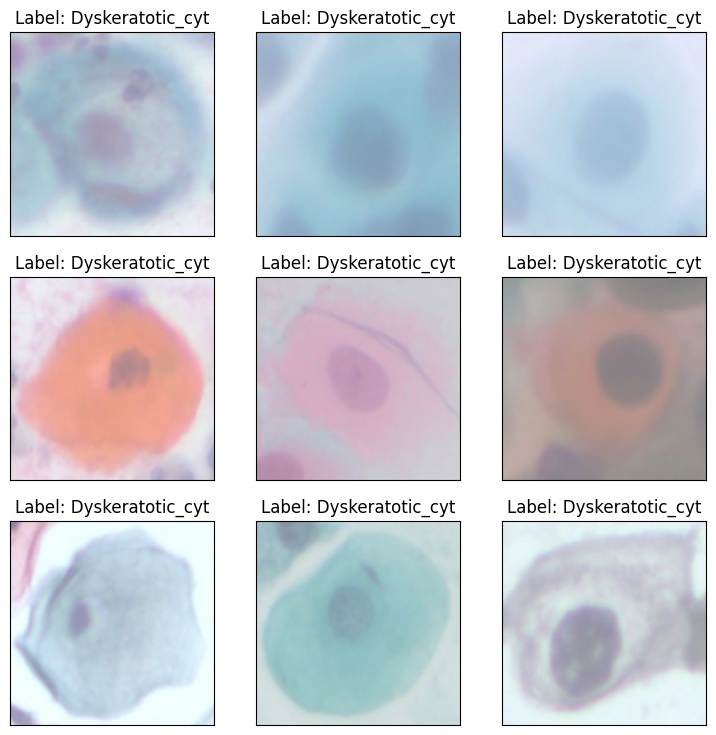

In [77]:
import os
import glob
from PIL import Image

# Define the directory path of your dataset
dataset_path = "/content/Cervical-Cancer-Classification-2"

# List all image files in the dataset directory
image_files = glob.glob(os.path.join(dataset_path, "*.jpg"))  # Adjust the file extension based on your dataset

# Load images and labels from the dataset
images = []
labels = []

for image_file in image_files:
    # Load image
    image = Image.open(image_file)
    images.append(image)

    # Extract label from the filename or any other method specific to your dataset
    label = extract_label_from_filename(image_file)  # Implement this function based on your dataset
    labels.append(label)

# Convert images and labels to numpy arrays or any other suitable format
images = np.array(images)
labels = np.array(labels)

# Now you can proceed with the rest of your code to display images with labels
show_images_with_labels(batch, label_names=label_names)

# Load Pretrained Model

In [82]:
model_config = models_config.MODEL_CONFIGS[model_name]
model_config

classifier: token
hidden_size: 768
model_name: ViT-B_32
patches:
  size: !!python/tuple
  - 32
  - 32
representation_size: null
transformer:
  attention_dropout_rate: 0.0
  dropout_rate: 0.0
  mlp_dim: 3072
  num_heads: 12
  num_layers: 12

In [83]:
# Load model definition & initialize random parameters.
# This also compiles the model to XLA (takes some minutes the first time).
if model_name.startswith('Mixer'):
  model = models.MlpMixer(num_classes=num_classes, **model_config)
else:
  model = models.VisionTransformer(num_classes=num_classes, **model_config)
variables = jax.jit(lambda: model.init(
    jax.random.PRNGKey(0),
    # Discard the "num_local_devices" dimension of the batch for initialization.
    batch['image'][0, :1],
    train=False,
), backend='cpu')()

TypeError: tuple indices must be integers or slices, not str

In [84]:
variables = jax.jit(lambda: model.init(
    jax.random.PRNGKey(0),
    # Accessing the first element of the tuple directly
    batch[0][0:1],  # Assuming 'image' is the first element of the tuple
    train=False,
), backend='cpu')()


In [29]:
# Load and convert pretrained checkpoint.
# This involves loading the actual pre-trained model results, but then also also
# modifying the parameters a bit, e.g. changing the final layers, and resizing
# the positional embeddings.
# For details, refer to the code and to the methods of the paper.
params = checkpoint.load_pretrained(
    pretrained_path=f'{model_name}.npz',
    init_params=variables['params'],
    model_config=model_config,
)

INFO:absl:Inspect extra keys:
{'pre_logits/bias', 'pre_logits/kernel'}
INFO:absl:load_pretrained: drop-head variant
INFO:absl:load_pretrained: resized variant: (1, 50, 768) to (1, 17, 768)
INFO:absl:interpolate_posembed: grid-size from 7 to 4


# Evaluate

In [30]:
# So far, all our data is in the host memory. Let's now replicate the arrays
# into the devices.
# This will make every array in the pytree params become a ShardedDeviceArray
# that has the same data replicated across all local devices.
# For TPU it replicates the params in every core.
# For a single GPU this simply moves the data onto the device.
# For CPU it simply creates a copy.
params_repl = flax.jax_utils.replicate(params)
print('params.cls:', type(params['head']['bias']).__name__,
      params['head']['bias'].shape)
print('params_repl.cls:', type(params_repl['head']['bias']).__name__,
      params_repl['head']['bias'].shape)

params.cls: ArrayImpl (5,)
params_repl.cls: ArrayImpl (1, 5)


In [31]:
# Then map the call to our model's forward pass onto all available devices.
vit_apply_repl = jax.pmap(lambda params, inputs: model.apply(
    dict(params=params), inputs, train=False))

In [32]:
def get_accuracy(params_repl):
  """Returns accuracy evaluated on the test set."""
  good = total = 0
  steps = input_pipeline.get_dataset_info(dataset, 'test')['num_examples'] // batch_size
  for _, batch in zip(tqdm.trange(steps), ds_test.as_numpy_iterator()):
    predicted = vit_apply_repl(params_repl, batch['image'])
    is_same = predicted.argmax(axis=-1) == batch['label'].argmax(axis=-1)
    good += is_same.sum()
    total += len(is_same.flatten())
  return good / total